In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [9]:
base_dir = Path().resolve()


classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [12]:
def read_metrics(filepath: Path):
    metrics_df = pd.read_json(filepath, orient="records", lines=True)
    mdf = metrics_df.sort_values("iteration")
    return mdf


def plot(mdf: pd.DataFrame):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # loss
    mdf1 = mdf[~mdf["total_loss"].isna()]
    axes[0].plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
    if "validation_loss" in mdf.columns:
        mdf2 = mdf[~mdf["validation_loss"].isna()]
        axes[0].plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")
    axes[0].legend()
    axes[0].set_title("Loss curve")
    
    # AP
    mdf3 = mdf[~mdf["bbox/AP75"].isna()]
    axes[1].plot(mdf3["iteration"], mdf3["bbox/AP75"] / 100., c="C2", label="validation")

    axes[1].legend()
    axes[1].set_title("AP40")
    
    # AP by class
    mdf_bbox_class = mdf3.iloc[-1][[f"bbox/AP-{col}" for col in classes_nms]]
    mdf_bbox_class.plot(kind="bar", ax=axes[2])
    _ = axes[2].set_title("AP by class")
    
    plt.show()

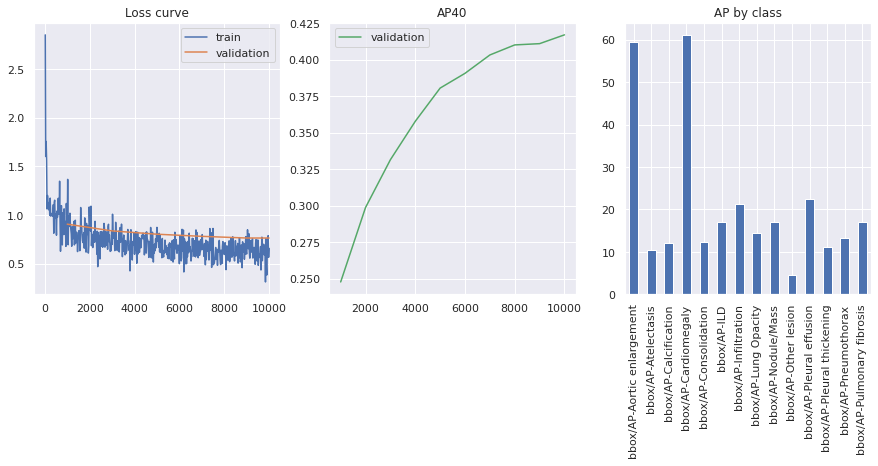

In [22]:
for nm in ['retinanet_R_101_FPN_3x_mkf_5']:
    mdf = read_metrics(base_dir / f'detectron2_results/{nm}/fold-1/metrics.json')
    plot(mdf)
    break